In [1]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn import manifold
import matplotlib.pyplot as plt
import os
from functools import partial
import umap

In [2]:
import umap

In [3]:
path = "C:\\Users\\user\\Documents\\Workspace\\ContrastiveLearning"
data = np.load(os.path.join(path,'data','ResNet_32_avgpool_small.npy'))
tensor_data = tf.convert_to_tensor(data)

In [4]:
n_samples,n_feature = tensor_data.shape
noisy = tensor_data[:n_samples//2]
clean = tensor_data[n_samples//2:]

In [5]:
X_embedded = TSNE(n_components=2,
                  perplexity=60.0,
                  learning_rate=70.0,
                  n_iter = 500).fit_transform(data)



In [6]:
reducer = umap.UMAP(n_components=2,target_n_neighbors=15)
embedding = reducer.fit_transform(data)

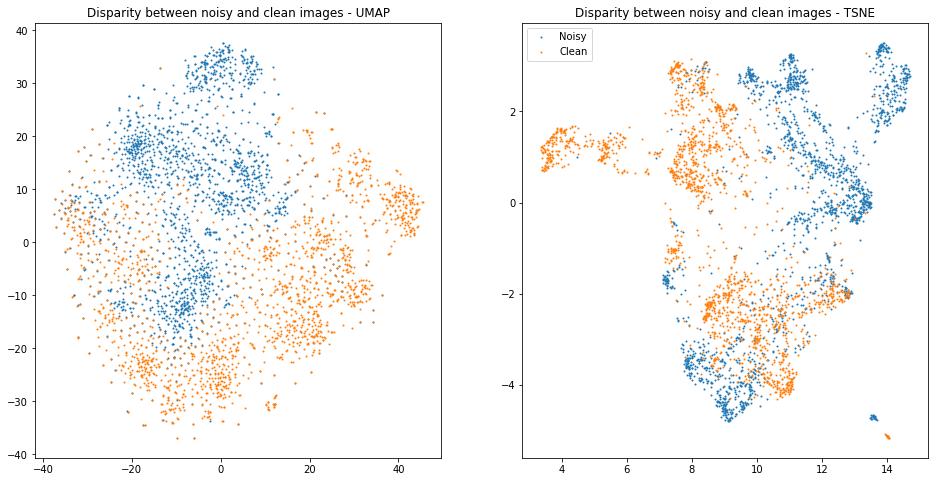

In [7]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
ax[1].scatter(embedding[:n_samples//2,0],embedding[:n_samples//2,1], s=1,label = 'Noisy')
ax[1].scatter(embedding[n_samples//2:,0],embedding[n_samples//2:,1], s=1, label = 'Clean')
ax[1].set_title('Disparity between noisy and clean images - TSNE')

ax[0].scatter(X_embedded[:n_samples//2,0],X_embedded[:n_samples//2,1], s=1,label = 'Noisy')
ax[0].scatter(X_embedded[n_samples//2:,0],X_embedded[n_samples//2:,1], s=1,label = 'Clean')
ax[0].set_title('Disparity between noisy and clean images - UMAP')
plt.legend()
plt.show()

2D representation generated with both T-SNE and UMAP show a clear disparity between the noisy and clean image domains.

In [8]:
anchor_dataset =  tf.data.Dataset.from_tensor_slices(clean)
positive_dataset =  tf.data.Dataset.from_tensor_slices(noisy)
negative_dataset =  tf.data.Dataset.from_tensor_slices(tf.roll(noisy,shift=2,axis=0))
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=128)

train_dataset = dataset.take(round((n_samples//2) * 0.8))
val_dataset = dataset.skip(round((n_samples//2) * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [9]:
class SiameseModel(tf.keras.Model):
    """The Siamese Network model with triplet loss.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [10]:
class SiameseModelSim(tf.keras.Model):
    """The Siamese Network model with similarity loss from SimCLR.

    Computes the similarity loss using the three embeddings produced by the
    Siamese Network.

    The similarity loss (SimCLR) is defined as:
       L(A, P, N) = -log(e^(f(A)*f(P))/(e^(f(A)*f(P))+e^(f(A)*f(N))))
    """

    def __init__(self, siamese_network):
        super(SiameseModelSim, self).__init__()
        self.siamese_network = siamese_network
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_sim, an_sim = self.siamese_network(data)

        loss = -tf.math.log(tf.math.exp(ap_sim)/(tf.math.exp(ap_sim)+tf.math.exp(an_sim)))
        
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

class SimilarityLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the similarity between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding. Similarity is computed as cosine similarity raised to e.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_sim = tf.reduce_sum(anchor*positive,axis=1)/(tf.norm(anchor,axis=1)*tf.norm(positive,axis=1))
        an_sim = tf.reduce_sum(anchor*negative,axis=1)/(tf.norm(anchor,axis=1)*tf.norm(negative,axis=1))
        return (ap_sim, an_sim)


In [11]:
def generate_new_embeddings(val_dataset, embedding_network):
    anchors = []
    positives = []

    for sample in val_dataset:

        anchor, positive, _ = sample
        anchor_embedding, positive_embedding = (
            embedding_network((anchor)),
            embedding_network((positive)),
        )
        anchors.append(anchor_embedding)
        positives.append(positive_embedding)

    new_data = np.concatenate([np.concatenate(anchors),
                               np.concatenate(positives)])
    
    return new_data

def plot_new_embeddings(new_data,loss):
    X_embedded = TSNE(n_components=2,
                      perplexity=60.0,
                      learning_rate=70.0,
                      n_iter = 500).fit_transform(new_data)

    reducer = umap.UMAP(n_components=2,target_n_neighbors=15)
    embedding = reducer.fit_transform(new_data)

    fig,ax = plt.subplots(1,2, figsize = (16,8))
    ax[1].scatter(X_embedded[:new_data.shape[0]//2,0],X_embedded[:new_data.shape[0]//2,1], s=1,label = 'Noisy')
    ax[1].scatter(X_embedded[new_data.shape[0]//2:,0],X_embedded[new_data.shape[0]//2:,1], s=1, label = 'Clean')
    ax[1].set_title('Disparity between noisy and clean images - TSNE')

    ax[0].scatter(embedding[:new_data.shape[0]//2,0],embedding[:new_data.shape[0]//2,1], s=1,label = 'Noisy')
    ax[0].scatter(embedding[new_data.shape[0]//2:,0],embedding[new_data.shape[0]//2:,1], s=1, label = 'Clean')
    ax[0].set_title('Disparity between noisy and clean images - UMAP')
    plt.suptitle('After Contrastive learning with '+loss+' loss')

    plt.legend()
    plt.show()

In [12]:
embedding_network = tf.keras.Sequential(layers=[tf.keras.layers.Dense(256, activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(128,activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(64)
                                       ],
                                name="Embedding")

anchor_input = tf.keras.layers.Input(name="anchor", shape= (n_feature))
positive_input = tf.keras.layers.Input(name="positive", shape= (n_feature))
negative_input = tf.keras.layers.Input(name="negative", shape= (n_feature) )

distances = DistanceLayer()(
    embedding_network(anchor_input),
    embedding_network(positive_input),
    embedding_network(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)
siamese_model = SiameseModel(siamese_network,margin=0.3)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00005))
siamese_model.fit(train_dataset, epochs=25, validation_data=val_dataset)


Epoch 1/25
46/46 [==============================] - 3s 38ms/step - loss: 0.2436 - val_loss: 0.2658
Epoch 2/25
46/46 [==============================] - 0s 10ms/step - loss: 0.2297 - val_loss: 0.2605
Epoch 3/25
46/46 [==============================] - 0s 10ms/step - loss: 0.2146 - val_loss: 0.2540
Epoch 4/25
46/46 [==============================] - 0s 9ms/step - loss: 0.2017 - val_loss: 0.2443
Epoch 5/25
46/46 [==============================] - 0s 9ms/step - loss: 0.1870 - val_loss: 0.2386
Epoch 6/25
46/46 [==============================] - 0s 10ms/step - loss: 0.1727 - val_loss: 0.2264
Epoch 7/25
46/46 [==============================] - 0s 10ms/step - loss: 0.1598 - val_loss: 0.2163
Epoch 8/25
46/46 [==============================] - 0s 10ms/step - loss: 0.1465 - val_loss: 0.2133
Epoch 9/25
46/46 [==============================] - 0s 11ms/step - loss: 0.1363 - val_loss: 0.2064
Epoch 10/25
46/46 [==============================] - 0s 10ms/step - loss: 0.1252 - val_loss: 0.2001
Epoch 11/25

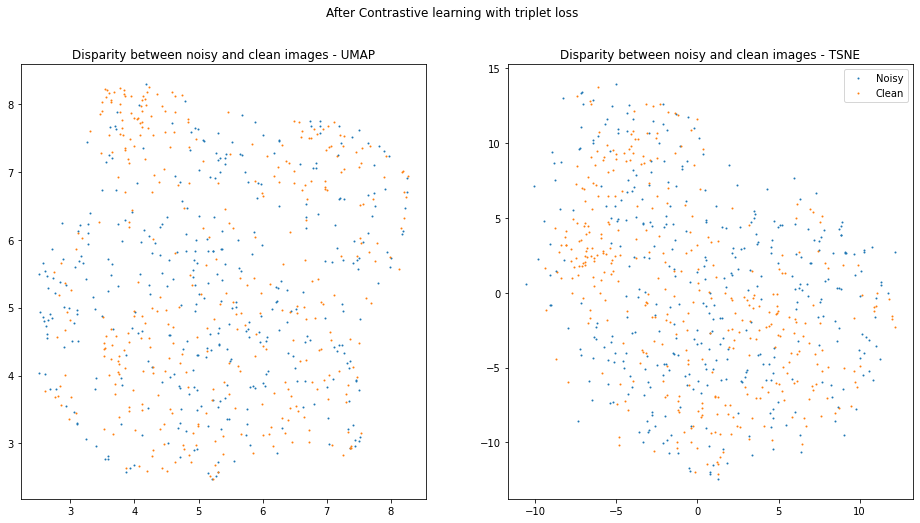

In [13]:
generated_data = generate_new_embeddings(val_dataset,embedding_network)
plot_new_embeddings(generated_data,loss = 'triplet')

In [14]:
embedding_network = tf.keras.Sequential(layers=[tf.keras.layers.Dense(256, activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(128,activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(64)
                                       ],
                                name="Embedding")

anchor_input = tf.keras.layers.Input(name="anchor", shape= (n_feature))
positive_input = tf.keras.layers.Input(name="positive", shape= (n_feature))
negative_input = tf.keras.layers.Input(name="negative", shape= (n_feature) )

similarities = SimilarityLayer()(
    embedding_network(anchor_input),
    embedding_network(positive_input),
    embedding_network(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=similarities
)
siamese_model = SiameseModelSim(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.000012))
siamese_model.fit(train_dataset, epochs=25, validation_data=val_dataset)


Epoch 1/25
46/46 [==============================] - 2s 14ms/step - loss: 0.6923 - val_loss: 0.6920
Epoch 2/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6905 - val_loss: 0.6889
Epoch 3/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6797 - val_loss: 0.6745
Epoch 4/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6546 - val_loss: 0.6601
Epoch 5/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6347 - val_loss: 0.6514
Epoch 6/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6218 - val_loss: 0.6365
Epoch 7/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6133 - val_loss: 0.6391
Epoch 8/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6100 - val_loss: 0.6337
Epoch 9/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6066 - val_loss: 0.6419
Epoch 10/25
46/46 [==============================] - 1s 11ms/step - loss: 0.6042 - val_loss: 0.6299
Epoch 11/

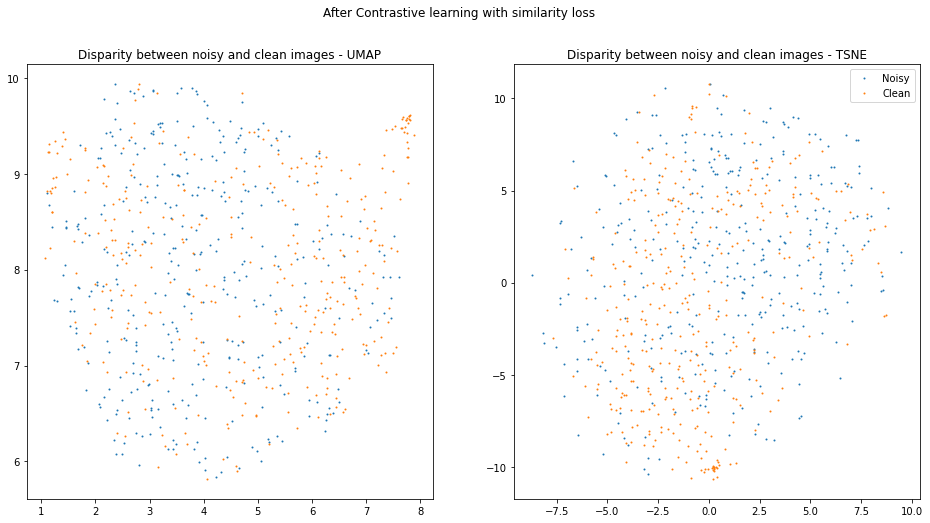

In [15]:
generated_data = generate_new_embeddings(val_dataset,embedding_network)
plot_new_embeddings(generated_data,loss = 'similarity')

On comparing results of using triplet loss vs similarity loss, we see that triplet loss gives better mixing of the two domains (clean and noisy). This can be attributed to the fact the similarity loss is generally used when more than one negative example is present in each batch. Here for simplicity and comparison with triplet loss one positive and one negative sample is taken for computing  similarity loss. In both cases we see that the newly generated representations are not seperable when transformed to a 2D representation. This implies that the model has learned a representation that minimizes the distance between similar objects.

For the purpose of this experiment, margin hyperparamter was optimized upon. Best results were obtained for margin=0.3

### Experiment with using the data with two sets of negative data points

Training data can be increased by considering multiple negative examples against the same positive example. Here we double the data size by adding a second set with different negative examples.

In [16]:
anchor_dataset =  tf.data.Dataset.from_tensor_slices(tf.concat([clean[:round((n_samples//2) * 0.8)],
                                                                clean[:round((n_samples//2) * 0.8)]],axis=0))
positive_dataset =  tf.data.Dataset.from_tensor_slices(tf.concat([noisy[:round((n_samples//2) * 0.8)],
                                                                  noisy[:round((n_samples//2) * 0.8)]],axis=0))
negative_dataset =  tf.data.Dataset.from_tensor_slices(tf.concat([tf.roll(noisy,shift=2,axis=0)[:round((n_samples//2) * 0.8)],
                                                                 tf.roll(noisy,shift=4,axis=0)[:round((n_samples//2) * 0.8)]],
                                                                 axis=0))
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=128)

train_dataset = dataset.take(round(n_samples*0.8))
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

anchor_dataset =  tf.data.Dataset.from_tensor_slices(clean[round((n_samples//2) * 0.8):])
positive_dataset =  tf.data.Dataset.from_tensor_slices(noisy[round((n_samples//2) * 0.8):])
negative_dataset =  tf.data.Dataset.from_tensor_slices(tf.roll(noisy,shift=2,axis=0)[round((n_samples//2) * 0.8):])

val_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [17]:
embedding_network = tf.keras.Sequential(layers=[tf.keras.layers.Dense(256, activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(128,activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(64)
                                       ],
                                name="Embedding")

anchor_input = tf.keras.layers.Input(name="anchor", shape= (n_feature))
positive_input = tf.keras.layers.Input(name="positive", shape= (n_feature))
negative_input = tf.keras.layers.Input(name="negative", shape= (n_feature) )

distances = DistanceLayer()(
    embedding_network(anchor_input),
    embedding_network(positive_input),
    embedding_network(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)
siamese_model = SiameseModel(siamese_network,margin=0.3)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00005))
siamese_model.fit(train_dataset, epochs=25, validation_data=val_dataset)


Epoch 1/25
92/92 [==============================] - 2s 10ms/step - loss: 0.2237 - val_loss: 0.2383
Epoch 2/25
92/92 [==============================] - 1s 8ms/step - loss: 0.1916 - val_loss: 0.2250
Epoch 3/25
92/92 [==============================] - 1s 9ms/step - loss: 0.1642 - val_loss: 0.2100
Epoch 4/25
92/92 [==============================] - 1s 9ms/step - loss: 0.1406 - val_loss: 0.1986
Epoch 5/25
92/92 [==============================] - 1s 8ms/step - loss: 0.1201 - val_loss: 0.1906
Epoch 6/25
92/92 [==============================] - 1s 8ms/step - loss: 0.1035 - val_loss: 0.1833
Epoch 7/25
92/92 [==============================] - 1s 9ms/step - loss: 0.0888 - val_loss: 0.1779
Epoch 8/25
92/92 [==============================] - 1s 8ms/step - loss: 0.0778 - val_loss: 0.1733
Epoch 9/25
92/92 [==============================] - 1s 8ms/step - loss: 0.0674 - val_loss: 0.1693
Epoch 10/25
92/92 [==============================] - 1s 8ms/step - loss: 0.0586 - val_loss: 0.1662
Epoch 11/25
92/92 

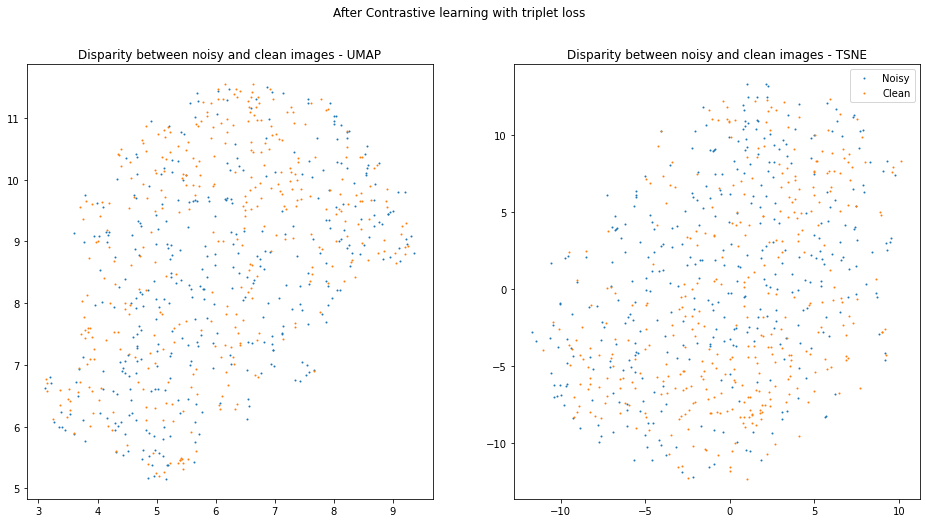

In [18]:
generated_data = generate_new_embeddings(val_dataset,embedding_network)
plot_new_embeddings(generated_data,loss = 'triplet')

In [19]:
embedding_network = tf.keras.Sequential(layers=[tf.keras.layers.Dense(256, activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(128,activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(64)
                                       ],
                                name="Embedding")

anchor_input = tf.keras.layers.Input(name="anchor", shape= (n_feature))
positive_input = tf.keras.layers.Input(name="positive", shape= (n_feature))
negative_input = tf.keras.layers.Input(name="negative", shape= (n_feature) )

similarities = SimilarityLayer()(
    embedding_network(anchor_input),
    embedding_network(positive_input),
    embedding_network(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=similarities
)
siamese_model = SiameseModelSim(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.000012))
siamese_model.fit(train_dataset, epochs=25, validation_data=val_dataset)


Epoch 1/25
92/92 [==============================] - 2s 11ms/step - loss: 0.6922 - val_loss: 0.6917
Epoch 2/25
92/92 [==============================] - 1s 9ms/step - loss: 0.6848 - val_loss: 0.6771
Epoch 3/25
92/92 [==============================] - 1s 9ms/step - loss: 0.6439 - val_loss: 0.6482
Epoch 4/25
92/92 [==============================] - 1s 11ms/step - loss: 0.6174 - val_loss: 0.6455
Epoch 5/25
92/92 [==============================] - 1s 9ms/step - loss: 0.6098 - val_loss: 0.6437
Epoch 6/25
92/92 [==============================] - 1s 9ms/step - loss: 0.6046 - val_loss: 0.6426
Epoch 7/25
92/92 [==============================] - 1s 9ms/step - loss: 0.6026 - val_loss: 0.6422
Epoch 8/25
92/92 [==============================] - 1s 9ms/step - loss: 0.5988 - val_loss: 0.6425
Epoch 9/25
92/92 [==============================] - 1s 9ms/step - loss: 0.5964 - val_loss: 0.6409
Epoch 10/25
92/92 [==============================] - 1s 9ms/step - loss: 0.5949 - val_loss: 0.6387
Epoch 11/25
92/92

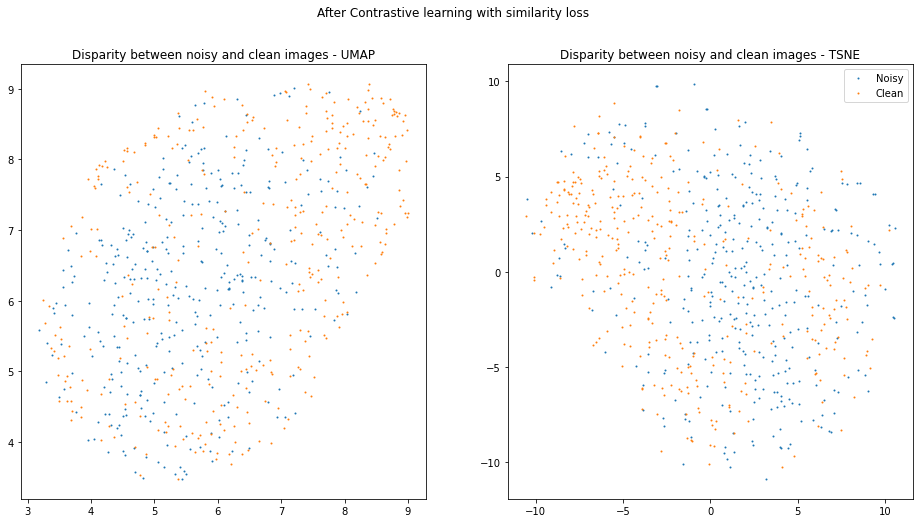

In [20]:
generated_data = generate_new_embeddings(val_dataset,embedding_network)
plot_new_embeddings(generated_data,loss = 'similarity')

Adding additional data points does not improve the performance of the model significantly with triplet loss. Some improvement is seen in preformance of similarity loss. However, model with this loss function tends to converge much faster than triplet loss and often overfits. The learning rate needed for this loss function is also much lower than triplet loss